# *The Supermassive Problem* Code Release

This notebook reproduces the plots from *The Supermassive Problem: Probing Potential Stellar Formation Pathways of Light Intermediate-Mass Black Holes.*

This code uses functions developed by Rich Townsend, available in the separate file `functions.py`.

This code was developed with the help of AI models Microsoft Copilot, Github Copilot, and ChatGPT.

Dependencies: `numpy` and `matplotlib`.


In [ ]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from functions import read_history

# Set this to be the folder containing the code and data files
default_directory = "C:/path/to/your/folder/The_Supermassive_Problem"
os.chdir(default_directory)

# Set these to be the three data files (default names should work if unchanged)
file1 = "solar_history.data"
file2 = "LMC_history.data"
file3 = "PopII_history.data"

plt.figure()  # initialize matplotlib backend

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
# ---------------------------------------------------------------------------
# Core analysis and plotting functions for MESA stellar evolution data
# ---------------------------------------------------------------------------

def sampled_list(seq, count):
    
    """
    Sample a list evenly.

    Given a sequence (e.g., time, mass, luminosity) and a target count,
    this returns roughly evenly spaced points throughout the sequence.
    """

    if count <= 0:
        return []
    spacing = max(1, len(seq) // count)
    return [seq[i] for i in range(0, len(seq), spacing)]


def print_history(path, parameter, count=None, space=False, keys=False):
    
    """
    Retrieve a specific data parameter from a MESA history file.

    Parameters
    ----------
    path : str
        Path to the 'history.data' file.
    parameter : str
        The column name to extract (e.g., 'star_mass', 'log_L').
    count : int, optional
        Number of samples to return (for shorter plots or exports).
    space : bool, optional
        If True, use evenly spaced sampling (via sampled_list()).
    keys : bool, optional
        If True, print all available keys for inspection.

    Returns
    -------
    list or array of parameter values.
    """

    hist = read_history(path)
    if keys:
        print(hist.keys())

    if parameter not in hist:
        raise KeyError(f"Parameter '{parameter}' not found in {path!r}")

    if count is None or count > len(hist[parameter]):
        count = len(hist[parameter])

    if not space:
        return hist[parameter][count:]
    return sampled_list(hist[parameter], count)

def xlmdot(history_path, metallicity):
    
    """
    Compute an empirical log mass-loss rate (log10 Mdot), 
    as described in Sander & Vink (2020).

    Parameters
    ----------
    history_path : str
        Path to the MESA history.data file.
    metallicity : float
        Stellar metallicity (Z).

    Returns
    -------
    numpy.ndarray
        log10(Mdot / M_sun yr^-1), aligned with the model's star_age.
    """

    p = Path(history_path).expanduser().resolve()
    if not p.exists():
        raise FileNotFoundError(f"No history file found at {p!r}")

    hist = read_history(str(p))

    # Ensure required columns exist
    for col in ("star_age", "surface_h1", "log_L", "star_mass"):
        if col not in hist:
            raise KeyError(f"'{col}' missing from {p.name}")

    # Extract physical quantities from the MESA history
    age = np.array(hist["star_age"], dtype=float)
    sh1 = np.array(hist["surface_h1"], dtype=float)
    logL = np.array(hist["log_L"], dtype=float)
    mstar = np.array(hist["star_mass"], dtype=float)

    # Compute the Eddington factor gamma_Edd
    gamma_edd = 10 ** (-4.813 + np.log10(1.0 + sh1) + logL - np.log10(mstar))
    logZ_div_Zsun = np.log10(metallicity / 0.0142)

    # Empirical fit coefficients from mass-loss scaling relations
    a = 2.932
    geddb = -0.324 * logZ_div_Zsun + 0.244
    cbd = -0.44 * logZ_div_Zsun + 9.15
    logOff = 0.23 * logZ_div_Zsun - 2.61

    # Combine terms into total log10(Mdot)
    logMdot_pureWR = a * np.log10(-np.log10(1.0 - gamma_edd)) + logOff
    logMdot_break = np.log10(2.0) * (geddb / gamma_edd) ** cbd

    return logMdot_pureWR + logMdot_break


def plot_history(path, xvalue, yvalue1,
                 yvalue2=None, ylabel1=None, ylabel2=None,
                 color1=None, color2=None, style1='-', style2='-',
                 count=None, xlabel=None, ylabel=None, title=None,
                 reversex=False, logx=False, logy=False,
                 xbottom=None, xtop=None, ybottom=None, ytop=None,
                 hidePlot=False, isoradii=None, metallicity=None,
                 grid=False):
    
    """
    Plot stellar evolution data from a MESA history file.

    Parameters
    ----------
    path : str
        Path to 'history.data'.
    xvalue, yvalue1, yvalue2 : str
        Keys for x-axis and one or two y-axis parameters.
    ylabel1, ylabel2 : str, optional
        Legend labels for plotted curves.
    color1, color2 : str, optional
        Line colors for each dataset.
    style1, style2 : str, optional
        Line styles.
    reversex : bool
        Reverse x-axis (used for "time to collapse" plots).
    logx, logy : bool
        Apply logarithmic axes.
    isoradii : list, optional
        Overlay constant-radius isolines (for H–R diagrams).
    metallicity : float, optional
        Required when plotting xlmdot (mass-loss correction).
    grid : bool
        Display grid lines.
    """
    
    hist = read_history(path)

    # --- X-axis setup ---
    if xvalue == "timestep":
        xlist = np.arange(0, len(hist[yvalue1]) + 1)
    else:
        xlist = print_history(path, xvalue, count=count, space=True)

    # --- Y-axis setup ---
    def resolve_y(yval):
        """Handle derived parameters or direct data columns."""
        if yval is None:
            return None
        if yval == "xlmdot":
            return xlmdot(path, metallicity)
        return print_history(path, yval, count=count, space=True)

    list1 = resolve_y(yvalue1)
    list2 = resolve_y(yvalue2)

    # Reverse time (e.g., time until core collapse)
    if reversex:
        xlist = [max(xlist) - xi for xi in xlist]

    # --- Main plot ---
    plt.plot(xlist, list1, linestyle=style1, label=ylabel1, color=color1, zorder=100)
    if list2 is not None:
        plt.plot(xlist, list2, linestyle=style2, label=ylabel2, color=color2, zorder=101)

    # --- Axis setup ---
    if xbottom is not None and xtop is not None:
        plt.xlim(xbottom, xtop)
    if ybottom is not None and ytop is not None:
        plt.ylim(ybottom, ytop)
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # --- H–R Diagram Isoradius Overlay ---
    if isoradii is not None and xvalue == "log_Teff" and yvalue1 == "log_L":
        logT_min, logT_max = (xbottom, xtop) if (xbottom and xtop) else (min(xlist), max(xlist))
        logT_grid = np.linspace(logT_min, logT_max, 300)
        logT_sun = np.log10(5777.0)
        ax = plt.gca()

        for order, R in enumerate(isoradii):
            # Compute logL along constant radius line
            logL_iso = 2.0 * np.log10(R) + 4.0 * (logT_grid - logT_sun)
            ax.plot(logT_grid, logL_iso, color='darkgray', linestyle='--', alpha=0.75, zorder=order)

            # Label isolines only within visible range
            x_limits, y_limits = ax.get_xlim(), ax.get_ylim()
            mask = (logL_iso >= y_limits[0]) & (logL_iso <= y_limits[1])
            if not np.any(mask):
                continue

            ypos = (max(logL_iso[mask]) + min(logL_iso[mask])) / 2
            xpos = (max(logT_grid[mask]) + min(logT_grid[mask])) / 2
            slope_data = (max(logL_iso[mask]) - min(logL_iso[mask])) / (max(logT_grid[mask]) - min(logT_grid[mask]))
            aspect = (x_limits[1] - x_limits[0]) / (y_limits[1] - y_limits[0])
            slope_display = slope_data * aspect
            angle = np.degrees(np.arctan(slope_display)) + 5

            # Label each isoradius line
            ax.text(
                xpos, ypos, f'{R} R$_\\odot$', fontsize=10, color='darkgray',
                ha='center', va='center', rotation=angle,
                bbox=dict(facecolor='white', edgecolor='none', pad=0.6, alpha=0.8),
                zorder=order + 1
            )

    # --- Final styling ---
    if ylabel1 is not None:
        plt.legend()
    if grid:
        plt.grid()
    if not hidePlot:
        plt.show()

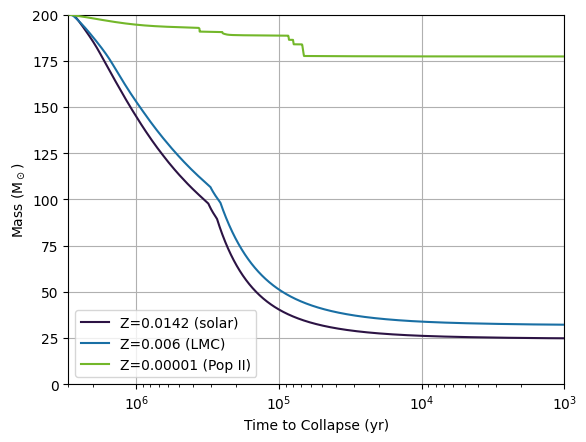

In [3]:
# Mass Evolution

plot_history(file1, "star_age", "star_mass",
             ylabel1="Z=0.0142 (solar)", color1="#2c1344",
             logx=True, reversex=True, hidePlot=True)
plot_history(file2, "star_age", "star_mass",
             ylabel1="Z=0.006 (LMC)", color1="#196fa4",
             logx=True, reversex=True, hidePlot=True)
plot_history(file3, "star_age", "star_mass",
             ylabel1="Z=0.00001 (Pop II)", color1="#73b72a",
             xlabel="Time to Collapse (yr)", ylabel="Mass (M$_\odot$)",
             logx=True, reversex=True, xbottom=3E6, xtop=1E3,
             ybottom=0, ytop=200, grid=True)

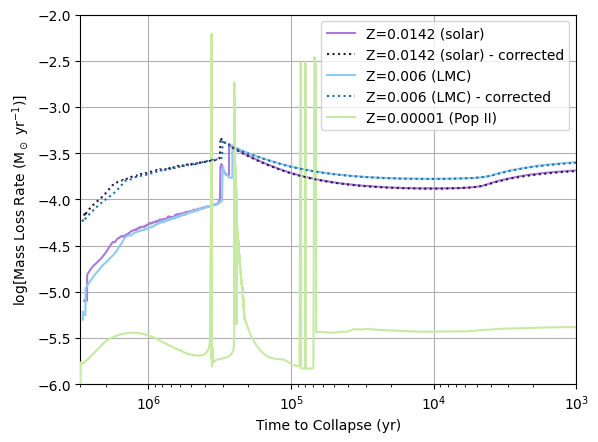

In [4]:
# Wind Strength Evolution

plot_history(file1, "star_age", "log_abs_mdot", "xlmdot",
             ylabel1="Z=0.0142 (solar)", ylabel2="Z=0.0142 (solar) - corrected",
             logx=True, reversex=True, metallicity=0.0142,
             color1="#ab7bda", color2="#2c1344", style1='-', style2=':', hidePlot=True)
plot_history(file2, "star_age", "log_abs_mdot", "xlmdot",
             ylabel1="Z=0.006 (LMC)", ylabel2="Z=0.006 (LMC) - corrected",
             logx=True, reversex=True, metallicity=0.006,
             color1="#90caee", color2="#196fa4", style1='-', style2=':', hidePlot=True)
plot_history(file3, "star_age", "log_abs_mdot",
             xlabel="Time to Collapse (yr)",
             ylabel1="Z=0.00001 (Pop II)",
             ylabel="log[Mass Loss Rate (M$_\odot$ yr$^{-1}$)]",
             logx=True, reversex=True, xbottom=3E6, xtop=1E3,
             ybottom=-6, ytop=-2, metallicity=0.00001,
             color1="#c7eaa2", style1='-', grid=True)

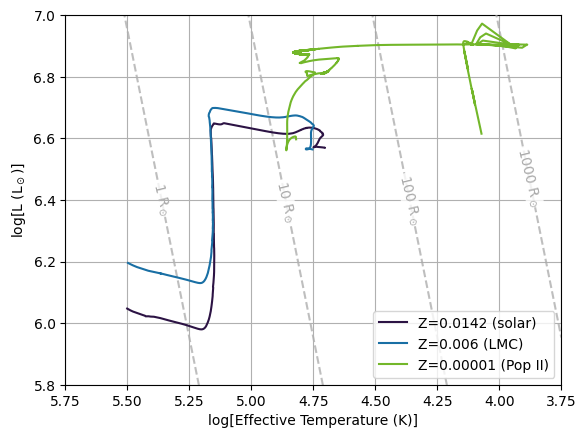

In [5]:
# H–R Diagram

plot_history(file1, "log_Teff", "log_L",
             ylabel1="Z=0.0142 (solar)", color1="#2c1344", hidePlot=True)
plot_history(file2, "log_Teff", "log_L",
             ylabel1="Z=0.006 (LMC)", color1="#196fa4", hidePlot=True)
plot_history(file3, "log_Teff", "log_L",
             ylabel1="Z=0.00001 (Pop II)", color1="#73b72a",
             xlabel="log[Effective Temperature (K)]", ylabel="log[L (L$_\odot$)]",
             xbottom=5.75, xtop=3.75, ybottom=5.8, ytop=7,
             isoradii=[1, 10, 100, 1000], grid=True)

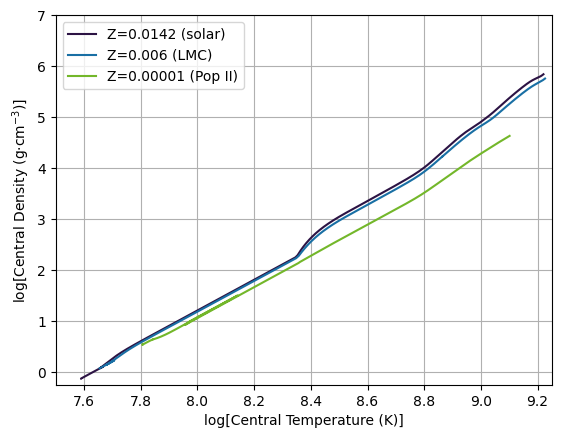

In [6]:
# Core Density–Temperature

plot_history(file1, "log_cntr_T", "log_cntr_Rho",
             ylabel1="Z=0.0142 (solar)", color1="#2c1344", hidePlot=True)
plot_history(file2, "log_cntr_T", "log_cntr_Rho",
             ylabel1="Z=0.006 (LMC)", color1="#196fa4", hidePlot=True)
plot_history(file3, "log_cntr_T", "log_cntr_Rho",
             ylabel1="Z=0.00001 (Pop II)", color1="#73b72a",
             xlabel="log[Central Temperature (K)]",
             ylabel="log[Central Density (g·cm$^{-3}$)]",
             xbottom=7.5, xtop=9.25, ybottom=-0.25, ytop=7, grid=True)